In [1]:
import qstock
import numpy as np
import pandas as pd

# 510300：沪深300ETF，代表大盘
# 510500：中证500ETF，代表小盘
# 510880：红利ETF，代表价值
# 159915：创业板ETF，代表成长
pool_list = ['510300', '510500', '510880', '159915']
start_date = '20250101'
data = qstock.get_price(pool_list, start=start_date, freq='d', fqt=2).sort_index()
name_list = data.columns.tolist()
data.head(10)

c:\Users\jishuaig\anaconda3\Lib\site-packages\pyfolio\pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


,红利ETF,创业板ETF,中证500ETF,沪深300ETF
date,,,,
2025-01-02,4.570,2.019,1.838,4.578
2025-01-03,4.539,1.978,1.801,4.538
2025-01-06,4.539,1.976,1.797,4.522
2025-01-07,4.525,1.990,1.816,4.549
2025-01-08,4.519,1.968,1.808,4.543
2025-01-09,4.475,1.971,1.807,4.535
2025-01-10,4.442,1.938,1.781,4.492
2025-01-13,4.415,1.942,1.784,4.477
2025-01-14,4.465,2.036,1.844,4.575


In [2]:
# 动量长度
N = 20
# 计算每日涨跌幅和N日涨跌幅
for name in name_list:
    data['日收益率_'+name] = data[name] / data[name].shift(1) - 1.0
    data['涨幅_'+name] = data[name] / data[name].shift(N+1) - 1.0
# 去掉缺失值
data = data.dropna()
data[['涨幅_'+v for v in name_list]].head(10)



,涨幅_红利ETF,涨幅_创业板ETF,涨幅_中证500ETF,涨幅_沪深300ETF
date,,,,
2025-02-10,-0.019694,0.060921,0.058760,0.018130
2025-02-11,-0.010134,0.068251,0.076069,0.023579
2025-02-12,-0.009694,0.088057,0.092376,0.035604
2025-02-13,-0.005967,0.072864,0.075991,0.027259
2025-02-14,-0.003983,0.104675,0.089049,0.035219
2025-02-17,0.002905,0.107052,0.087991,0.038589
2025-02-18,0.009905,0.104231,0.085907,0.042075
2025-02-19,0.012005,0.125129,0.100336,0.050257
2025-02-20,-0.002240,0.072692,0.067245,0.025137


In [3]:
# 取出每日涨幅最大的证券
data['信号'] = data[['涨幅_'+v for v in name_list]].idxmax(axis=1).str.replace('涨幅_', '')
# 今日的涨幅由昨日的持仓产生
data['信号'] = data['信号'].shift(1)
data = data.dropna()
data['轮动策略日收益率'] = data.apply(lambda x: x['日收益率_'+x['信号']], axis=1) 
# 第一天尾盘交易，当日涨幅不纳入
data.loc[data.index[0],'轮动策略日收益率'] = 0.0
data['轮动策略净值'] = (1.0 + data['轮动策略日收益率']).cumprod()
data[['涨幅_'+v for v in name_list]+['信号','轮动策略日收益率','轮动策略净值']].head(10)


,涨幅_红利ETF,涨幅_创业板ETF,涨幅_中证500ETF,涨幅_沪深300ETF,信号,轮动策略日收益率,轮动策略净值
date,,,,,,,
2025-02-11,-0.010134,0.068251,0.076069,0.023579,创业板ETF,0.000000,1.000000
2025-02-12,-0.009694,0.088057,0.092376,0.035604,中证500ETF,0.012900,1.012900
2025-02-13,-0.005967,0.072864,0.075991,0.027259,中证500ETF,-0.004585,1.008256
2025-02-14,-0.003983,0.104675,0.089049,0.035219,中证500ETF,0.007677,1.015996
2025-02-17,0.002905,0.107052,0.087991,0.038589,创业板ETF,0.003680,1.019735
2025-02-18,0.009905,0.104231,0.085907,0.042075,创业板ETF,-0.019248,1.000106
2025-02-19,0.012005,0.125129,0.100336,0.050257,创业板ETF,0.021028,1.021137
2025-02-20,-0.002240,0.072692,0.067245,0.025137,创业板ETF,-0.000458,1.020669
2025-02-21,-0.009164,0.120060,0.094040,0.042179,创业板ETF,0.025183,1.046373


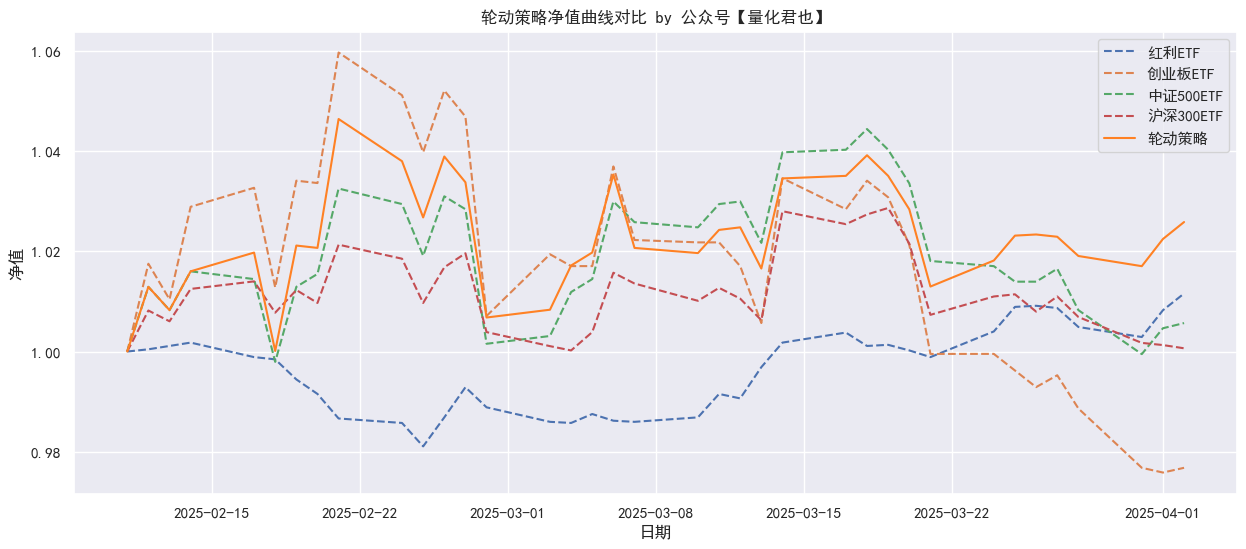

In [4]:


import matplotlib.pyplot as plt

# 显示中文设置
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

# 绘制净值曲线图
fig, ax = plt.subplots(figsize=(15, 6))
ax.set_xlabel('日期')
ax.set_ylabel('净值')
for name in name_list+['轮动策略']:
    if name in name_list:
        data[name+'净值'] = data[name]/data[name].iloc[0]
        ax.plot(data[name+'净值'].index, data[name+'净值'].values, linestyle='--')
    else:
        ax.plot(data[name+'净值'].index, data[name+'净值'].values, linestyle='-', color='#FF8124')

# 显示图例和标题
ax.legend(name_list+['轮动策略'])
ax.set_title('轮动策略净值曲线对比 by 公众号【量化君也】')

plt.show()

In [6]:


from sklearn.linear_model import LinearRegression

# 计算强弱得分
def calculate_score(srs, N=25):
    if srs.shape[0] < N:
        return np.nan
    x = np.arange(1, N+1)
    y = srs.values / srs.values[0]
    lr = LinearRegression().fit(x.reshape(-1, 1), y)
    # 斜率
    slope = lr.coef_[0]
    # 决定系数R2
    r_squared = lr.score(x.reshape(-1, 1), y)
    # 得分
    score = 10000 * slope * r_squared
    return score

# 斜率计算长度
N = 25
# 计算每日涨跌幅和得分
for name in name_list:
    data['日收益率_'+name] = data[name] / data[name].shift(1) - 1.0
    data['得分_'+name] = data[name].rolling(N).apply(lambda x: calculate_score(x, N))
# 去掉缺失值
data = data.dropna()
data[['得分_'+v for v in name_list]].head(10)

,得分_红利ETF,得分_创业板ETF,得分_中证500ETF,得分_沪深300ETF
date,,,,
2025-03-17,-0.125888,-0.000253,3.795840,0.281723
2025-03-18,-0.003035,-0.038855,3.950367,0.350331
2025-03-19,0.010739,-0.093729,4.747630,0.679743
2025-03-20,0.193136,-0.532427,4.340662,0.679320
2025-03-21,0.823371,-1.438356,3.031101,0.370441
2025-03-24,2.190762,-2.527792,1.859061,0.300500
2025-03-25,4.634138,-5.975558,0.402896,0.134632
2025-03-26,6.919025,-7.986996,0.065408,0.051105
2025-03-27,8.754731,-9.576223,0.002969,0.014248


In [7]:
import quantstats as qs

# 计算收益率序列
strategy_returns = data['轮动策略净值'].pct_change()
benchmark_returns = data['沪深300ETF净值'].pct_change()

# 输出基础报告
print("=== 基础统计指标 ===")
qs.reports.metrics(strategy_returns, benchmark=benchmark_returns, mode='basic')

print("\n=== 详细统计指标 ===")
qs.reports.metrics(strategy_returns, benchmark=benchmark_returns, mode='full')


=== 基础统计指标 ===
                    Benchmark    Strategy
------------------  -----------  ----------
Start Period        2025-03-18   2025-03-18
End Period          2025-04-02   2025-04-02
Risk-Free Rate      0.0%         0.0%
Time in Market      92.0%        92.0%

Cumulative Return   -2.6%        -1.28%
CAGR﹪              -35.75%      -19.48%

Sharpe              -7.08        -2.88
Prob. Sharpe Ratio  1.71%        25.07%
Sortino             -6.97        -3.36
Sortino/√2          -4.93        -2.38
Omega               0.6          0.6

Max Drawdown        -2.72%       -2.52%
Longest DD Days     14           15

Gain/Pain Ratio     -0.76        -0.4
Gain/Pain (1M)      -1.0         -0.6

Payoff Ratio        0.27         0.74
Profit Factor       0.24         0.6
Common Sense Ratio  0.08         0.3
CPC Index           0.02         0.2
Tail Ratio          0.33         0.51
Outlier Win Ratio   2.67         1.41
Outlier Loss Ratio  2.76         2.58

MTD                 -0.11%       0.87%
